## 使用 keras 做回归任务

### 导入数据

这里使用了 Boston Housing Price 数据集，一共 506 个样本，其中训练集 404 个样本，测试集 102 个样本。

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape, test_data.shape

Using TensorFlow backend.


57344/57026 [==============================] - 4s 77us/step


((404, 13), (102, 13))

In [8]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

### 预处理数据

对于样本的每个特征的含义暂且不深究，但有一点需要注意，不同的维度取值范围不同，为了更好地训练，需要将其值做归一化处理。做法就是每个维度减去均值，再除以标准差，归一化以后，各个维度的呈均值为 0 方差为 1 的正态分布。

In [13]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [14]:
train_data.mean(), train_data.std()

(2.6016254395785847e-15, 0.9999999999999993)

### 构建网络

In [11]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    # mse - Mean Squared Error
    # mae - Mean Absolute Error
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### 使用 k 折交叉验证

为了评估模型的效果，需要从训练集中划分出一个验证集。当数据量很少的时候，训练数据本就很小，划分出的验证集自然也不能很大。在一个小的验证集上得到的结果就显得不那么可靠。k 折交叉验证将数据分为 K 份，每次使用 K-1 份数据作为训练集，使用余下的 1 份作为验证集。这样训练 K 的模型，验证 K 次，最后求出 K 个评估指标的均值，作为最终评估结构。

![width=400](https://wangyu-name.oss-cn-hangzhou.aliyuncs.com/superbed/2019/05/07/5cd0f9253a213b0417e34cf2.jpg)

In [15]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]
    ], axis=0)
    
    partial_train_targets = np.concatenate([
        train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]
    ], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [29]:
print(all_scores)
print(np.mean(all_scores))

[2.0556031241275297, 2.276286233769785, 2.934723700627242, 2.407703190746874]
2.418579062317858


### 确定合适的 epoch

这里训练了 100 个 epoch，但并不知道多少个 epoch 合适，有可能不到 100 时就发生了过拟合。为了确定多少个 epoch 合适，可以记录下训练过程中在验证集上的 loss，当 loss 上升的时候，就可以认为出现了过拟合，以此就可以确定需要训练多少个 epoch 了。

In [18]:
num_epochs = 200
all_mae_histories = []

for i in range(k):
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([
        train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]
    ], axis=0)
    
    partial_train_targets = np.concatenate([
        train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]
    ], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = model.history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

In [19]:
average_mae_history = np.array(all_mae_histories).mean(axis=0)

在 K 折交叉验证过程中，记录下每个 epoch 的 MAE，然后求出这 K 折中各个 epoch 的平均 MAE，而后绘制曲线。

Text(0, 0.5, 'Validation MAE')

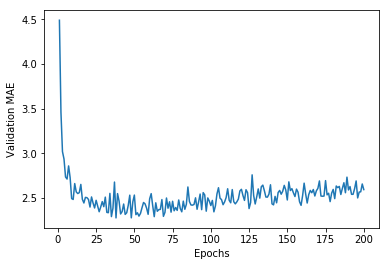

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

可以看到大约在前 10 个 epoch 过程中 loss 显著下降，但之后就看不太清楚了。一方面是因为前面的 loss 太大，后面的 loss 不在一个量级，因此后面的 loss 在纵轴上体现不出差异来。另外是毛刺太多。为了更容易观察，可以将曲线做平滑处理，并且抛掉前 10 个 epoch 的数据。

Text(0, 0.5, 'Validation MAE')

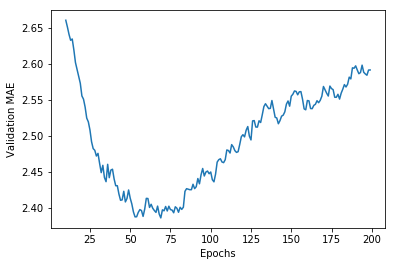

In [39]:
def smooth_curve(points, factor=0.9):
    if len(points) == 0:
        return []
    smoothed_points = [points[0]]
    for point in points[1:]:
        pre = smoothed_points[-1]
        smoothed_points.append(pre * factor + point * (1 - factor))
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(10, len(smooth_mae_history) + 10), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

可以看到模型在大约 60 个 epoch 之后就开始出现过拟合，可以重新训练一个模型，将 epoch 设置为 60。

### 训练最终的模型

训练模型，并在测试集上评估性能

In [27]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=60, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 2ms/step


2.489868173412248

最终在测试集上得到了 2.49 的 MAE，MAE 为 2.5 表示平均误差为 2.5。

In [41]:
train_targets.mean()

22.395049504950492

这里目标值的均值为 22.4 而平均误差为 2.5。这效果是好是坏，就要根据实际项目而论了。